In [35]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.base import BaseEstimator
from sklearn.metrics import ndcg_score

# Time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [36]:

file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/dati_with_context_f.csv' # cleaned data
df = pd.read_csv(file_path)
df = df.dropna(subset=['relative_quarterly_return'])

df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11723 entries, 1 to 11812
Data columns (total 64 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   tic                             11723 non-null  object 
 1   datadate                        11723 non-null  object 
 2   roa                             11692 non-null  float64
 3   roe                             11563 non-null  float64
 4   pe_inc                          11199 non-null  float64
 5   divyield                        9443 non-null   float64
 6   pcf                             11692 non-null  float64
 7   roce                            11586 non-null  float64
 8   gpm                             11711 non-null  float64
 9   evm                             11636 non-null  float64
 10  npm                             11712 non-null  float64
 11  PEG_trailing                    8110 non-null   float64
 12  de_ratio                        

,tic,datadate,roa,roe,pe_inc,divyield,pcf,roce,gpm,evm,...,r_roe,r_eg,divyield_Median,PEG_trailing_Median,pe_inc_Median,ptb_Median,evm_Median,roce_Median,roe_Median,bm_Median
11808,ZTS,2018-12-31,0.230,0.594,32.160,0.696,25.204,0.250,0.708,21.308,...,3.2636,4.3514,1.33,-0.101,-7.090,3.183,-4.273,-0.413,-0.531,0.227
11809,ZTS,2019-03-31,0.239,0.577,35.332,0.649,27.021,0.252,0.715,21.631,...,-3.5981,-5.1201,1.24,-0.079,-2.895,3.745,-2.919,-0.446,-0.452,0.308
11810,ZTS,2019-06-30,0.233,0.539,44.671,0.519,32.794,0.241,0.722,22.510,...,2.6492,1.1047,1.21,-0.115,-7.734,3.796,-3.920,-0.411,-0.512,0.251
11811,ZTS,2019-09-30,0.228,0.538,39.907,0.544,31.944,0.234,0.728,23.287,...,3.8375,0.8189,1.22,-0.092,-6.526,3.278,-3.883,-0.416,-0.509,0.258
11812,ZTS,2019-12-31,0.226,0.517,42.839,0.600,35.251,0.235,0.736,27.557,...,-1.9816,0.6485,1.10,-0.088,-8.014,3.910,-3.433,-0.447,-0.545,0.285


In [37]:
print(df.columns.tolist())
print(df.notna().sum().sort_values())



['tic', 'datadate', 'roa', 'roe', 'pe_inc', 'divyield', 'pcf', 'roce', 'gpm', 'evm', 'npm', 'PEG_trailing', 'de_ratio', 'ptb', 'market_cap', 'prccq_change', 'capxy_change', 'oancfy_change', 'actq_change', 'lctq_change', 'roa_change', 'roe_change', 'pe_inc_change', 'divyield_change', 'pcf_change', 'roce_change', 'gpm_change', 'evm_change', 'npm_change', 'PEG_trailing_change', 'de_ratio_change', 'ptb_change', 'next_prccq_change', 'relative_quarterly_return', 'next_relative_quarterly_return', 'volatility_score', 'FFI10_desc', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'umd', 'h_1_x', 'h_3_x', 'h_12_x', 'h_1_y', 'h_3_y', 'h_12_y', 'r_f', 'r_mkt', 'r_me', 'r_ia', 'r_roe', 'r_eg', 'divyield_Median', 'PEG_trailing_Median', 'pe_inc_Median', 'ptb_Median', 'evm_Median', 'roce_Median', 'roe_Median', 'bm_Median']
PEG_trailing_change     7371
PEG_trailing            8110
oancfy_change           8131
capxy_change            8602
lctq_change             9189
                       ...  
roe_Median   

In [38]:


df = df.loc[:, df.count() >= 11000]

# Drop rows with missing values
df = df.dropna()

# Display dataframe info
df.info()

print(df.columns.tolist())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10509 entries, 2 to 11812
Data columns (total 56 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   tic                             10509 non-null  object 
 1   datadate                        10509 non-null  object 
 2   roa                             10509 non-null  float64
 3   roe                             10509 non-null  float64
 4   pe_inc                          10509 non-null  float64
 5   pcf                             10509 non-null  float64
 6   roce                            10509 non-null  float64
 7   gpm                             10509 non-null  float64
 8   evm                             10509 non-null  float64
 9   npm                             10509 non-null  float64
 10  de_ratio                        10509 non-null  float64
 11  ptb                             10509 non-null  float64
 12  market_cap                      

In [39]:
# Find the unique number of stocks in the dataframe
unique_gvkeys = df['tic'].unique()

# Print the result
print(f"Number of unique gvkeys: {len(unique_gvkeys)}")
print(unique_gvkeys)


Number of unique gvkeys: 76
['AAPL' 'ABT' 'ADM' 'AFL' 'AIG' 'AMD' 'AMT' 'AMZN' 'APD' 'BA' 'BAX' 'BMY'
 'BRK.B' 'CAT' 'CL' 'CME' 'COP' 'CTSH' 'CVS' 'CVX' 'DIS' 'ECL' 'EQIX'
 'EXC' 'EXPE' 'F' 'FIS' 'GE' 'GOOGL' 'GS' 'HCA' 'IBM' 'INTC' 'JNJ' 'JPM'
 'KMB' 'KO' 'LLY' 'LMT' 'LUV' 'MA' 'MCD' 'META' 'MMC' 'MMM' 'MRK' 'MS'
 'MSFT' 'NFLX' 'NOC' 'OXY' 'PFE' 'PG' 'PGR' 'PPL' 'PYPL' 'QCOM' 'REGN'
 'RJF' 'RTX' 'SBUX' 'SCHW' 'SPGI' 'T' 'TMO' 'TSLA' 'TSN' 'UNH' 'UPS' 'V'
 'VZ' 'WBA' 'WDC' 'WFC' 'XOM' 'ZTS']


In [40]:
df = df.dropna()
df = df.sort_values(by=['datadate'])

unique_gvkeys = df['tic'].unique()

# Print the result
print(f"Number of unique gvkeys: {len(unique_gvkeys)}")

df.tail()

Number of unique gvkeys: 76


,tic,datadate,roa,roe,pe_inc,pcf,roce,gpm,evm,npm,...,r_roe,r_eg,divyield_Median,PEG_trailing_Median,pe_inc_Median,ptb_Median,evm_Median,roce_Median,roe_Median,bm_Median
876,AIG,2019-12-31,0.023,0.054,11.273,-37.158,0.066,0.236,7.292,0.067,...,-1.9816,0.6485,2.2,0.616,13.611,1.387,10.016,0.102,0.097,0.770
5972,JPM,2019-12-31,0.027,0.153,10.831,59.034,0.083,0.773,13.715,0.256,...,-1.9816,0.6485,2.2,0.616,13.611,1.387,10.016,0.102,0.097,0.770
5772,JNJ,2019-12-31,0.181,0.228,23.886,15.131,0.237,0.751,14.671,0.184,...,-1.9816,0.6485,1.1,-0.088,-8.014,3.910,-3.433,-0.447,-0.545,0.285
1932,BAX,2019-12-31,0.161,0.125,43.249,20.255,0.154,0.502,17.713,0.088,...,-1.9816,0.6485,2.2,0.616,13.611,1.387,10.016,0.102,0.097,0.770
11812,ZTS,2019-12-31,0.226,0.517,42.839,35.251,0.235,0.736,27.557,0.239,...,-1.9816,0.6485,1.1,-0.088,-8.014,3.910,-3.433,-0.447,-0.545,0.285


In [41]:
tickers_to_drop = ['AMT', 'CTSH', 'GOOGL', 'META', 'PYPL', 'RJF', 'TSLA', 'ZTS']

#df = df[~df['tic'].isin(tickers_to_drop)]

In [42]:
train_start_date = '1900-03-31'
valid_start_date = '2010-03-31'
test_start_date = '2013-03-31'
end_date = '2026-09-30'

df = df.sort_values(by=['datadate'])

train_df = df[(df['datadate'] >= train_start_date) & (df['datadate'] < valid_start_date)]
valid_df = df[(df['datadate'] >= valid_start_date) & (df['datadate'] < test_start_date)]
test_df = df[(df['datadate'] >= test_start_date) & (df['datadate'] < end_date)]

test_df = test_df.sort_values(by=['datadate', 'next_prccq_change'], ascending=[True, False])
test_df.tail()


,tic,datadate,roa,roe,pe_inc,pcf,roce,gpm,evm,npm,...,r_roe,r_eg,divyield_Median,PEG_trailing_Median,pe_inc_Median,ptb_Median,evm_Median,roce_Median,roe_Median,bm_Median
4330,EXPE,2019-12-31,0.095,0.138,26.159,4.793,0.111,0.828,11.237,0.047,...,-1.9816,0.6485,1.37,0.306,1.471,3.459,12.578,0.043,0.004,0.289
4530,F,2019-12-31,0.060,0.001,306.600,1.537,0.030,0.180,12.526,0.000,...,-1.9816,0.6485,2.31,0.416,11.098,2.718,9.116,0.098,0.085,0.413
2953,COP,2019-12-31,0.190,0.188,7.566,4.714,0.130,0.444,6.459,0.221,...,-1.9816,0.6485,2.55,0.090,3.964,0.919,5.440,0.061,0.047,1.103
876,AIG,2019-12-31,0.023,0.054,11.273,-37.158,0.066,0.236,7.292,0.067,...,-1.9816,0.6485,2.20,0.616,13.611,1.387,10.016,0.102,0.097,0.770
8520,OXY,2019-12-31,0.129,-0.023,-26.836,3.974,0.081,0.540,8.755,-0.032,...,-1.9816,0.6485,2.55,0.090,3.964,0.919,5.440,0.061,0.047,1.103


In [43]:
train_group = list(train_df['datadate'].value_counts().sort_index().tolist())
valid_group = list(valid_df['datadate'].value_counts().sort_index().tolist())
test_group = list(test_df['datadate'].value_counts().sort_index().tolist())

print(train_group)

[4, 24, 30, 32, 32, 31, 33, 34, 35, 32, 32, 37, 36, 35, 37, 38, 35, 37, 33, 33, 32, 36, 26, 26, 28, 37, 35, 34, 34, 37, 36, 36, 35, 38, 38, 38, 38, 40, 39, 39, 37, 36, 30, 32, 32, 35, 34, 39, 43, 39, 39, 44, 43, 41, 42, 46, 46, 43, 43, 49, 50, 50, 50, 50, 50, 51, 54, 52, 52, 48, 47, 52, 51, 50, 51, 52, 52, 50, 51, 52, 52, 50, 51, 53, 53, 52, 51, 52, 51, 53, 53, 51, 52, 53, 53, 54, 54, 52, 54, 54, 55, 55, 56, 56, 56, 57, 56, 57, 57, 56, 56, 57, 57, 59, 60, 59, 59, 58, 59, 60, 60, 59, 59, 59, 61, 61, 60, 61, 61, 60, 61, 63, 63, 63, 63, 63, 63, 63, 64, 63, 63, 64, 64, 65, 66, 66, 66, 66, 66, 66, 66, 67, 66, 63, 67, 67, 67, 64]


In [44]:
# Create a copy of the test results
results = test_df[['datadate', 'tic', 'next_prccq_change', 'next_relative_quarterly_return']].copy()

# Define columns to drop
drop_cols = ['datadate', 'tic', 'next_prccq_change', 'FFI10_desc']

# Drop the specified columns from train, validation, and test datasets
train_df = train_df.drop(columns=drop_cols)
valid_df = valid_df.drop(columns=drop_cols)
test_df  = test_df.drop(columns=drop_cols)

# Display the first few rows of the training dataset
train_df.head()


,roa,roe,pe_inc,pcf,roce,gpm,evm,npm,de_ratio,ptb,...,r_roe,r_eg,divyield_Median,PEG_trailing_Median,pe_inc_Median,ptb_Median,evm_Median,roce_Median,roe_Median,bm_Median
1335,0.145,0.093,17.928,8.009,0.117,0.507,7.570,0.057,1.440,1.387,...,-6.2954,-10.1619,3.51,0.908,14.712,1.435,9.151,0.102,0.087,0.612
3443,0.204,0.115,41.576,41.821,0.209,0.309,13.130,0.130,0.227,3.479,...,-6.2954,-10.1619,2.95,0.855,12.418,1.368,7.375,0.187,0.106,0.655
11213,0.112,0.094,14.020,16.465,0.122,0.276,7.442,0.013,1.215,1.280,...,-6.2954,-10.1619,3.70,1.084,12.710,1.218,7.059,0.166,0.091,0.689
7019,0.248,0.441,30.332,25.417,0.283,0.386,16.650,0.091,1.872,9.436,...,-6.2954,-10.1619,2.95,0.855,12.418,1.368,7.375,0.187,0.106,0.655
3444,0.204,0.105,47.375,56.869,0.209,0.309,13.130,0.135,0.227,4.730,...,5.6547,6.2280,2.71,1.046,13.920,1.415,7.319,0.183,0.115,0.673


In [45]:
# Define target variable (y) and features (X) for train, validation, and test sets
y_train = train_df['next_relative_quarterly_return'].copy()
X_train = train_df.drop(columns=['next_relative_quarterly_return'])

y_valid = valid_df['next_relative_quarterly_return'].copy()
X_valid = valid_df.drop(columns=['next_relative_quarterly_return'])

y_test  = test_df['next_relative_quarterly_return'].copy()
X_test  = test_df.drop(columns=['next_relative_quarterly_return'])

# Display the first few rows of X_train
X_train.head()


,roa,roe,pe_inc,pcf,roce,gpm,evm,npm,de_ratio,ptb,...,r_roe,r_eg,divyield_Median,PEG_trailing_Median,pe_inc_Median,ptb_Median,evm_Median,roce_Median,roe_Median,bm_Median
1335,0.145,0.093,17.928,8.009,0.117,0.507,7.570,0.057,1.440,1.387,...,-6.2954,-10.1619,3.51,0.908,14.712,1.435,9.151,0.102,0.087,0.612
3443,0.204,0.115,41.576,41.821,0.209,0.309,13.130,0.130,0.227,3.479,...,-6.2954,-10.1619,2.95,0.855,12.418,1.368,7.375,0.187,0.106,0.655
11213,0.112,0.094,14.020,16.465,0.122,0.276,7.442,0.013,1.215,1.280,...,-6.2954,-10.1619,3.70,1.084,12.710,1.218,7.059,0.166,0.091,0.689
7019,0.248,0.441,30.332,25.417,0.283,0.386,16.650,0.091,1.872,9.436,...,-6.2954,-10.1619,2.95,0.855,12.418,1.368,7.375,0.187,0.106,0.655
3444,0.204,0.105,47.375,56.869,0.209,0.309,13.130,0.135,0.227,4.730,...,5.6547,6.2280,2.71,1.046,13.920,1.415,7.319,0.183,0.115,0.673


In [46]:
# Scaling
scaler = MinMaxScaler()

# Fit the scaler on the training/validation data
X_train_scaled = scaler.fit_transform(X_train)

# Now apply the same scaling to the val/test data using the already fitted scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrame for consistency
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=X_valid.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

#X_train_scaled.info()

print(X_train_scaled.columns.tolist())


['roa', 'roe', 'pe_inc', 'pcf', 'roce', 'gpm', 'evm', 'npm', 'de_ratio', 'ptb', 'market_cap', 'prccq_change', 'roa_change', 'roe_change', 'pe_inc_change', 'pcf_change', 'roce_change', 'gpm_change', 'evm_change', 'npm_change', 'de_ratio_change', 'ptb_change', 'relative_quarterly_return', 'volatility_score', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'umd', 'h_1_x', 'h_3_x', 'h_12_x', 'h_1_y', 'h_3_y', 'h_12_y', 'r_f', 'r_mkt', 'r_me', 'r_ia', 'r_roe', 'r_eg', 'divyield_Median', 'PEG_trailing_Median', 'pe_inc_Median', 'ptb_Median', 'evm_Median', 'roce_Median', 'roe_Median', 'bm_Median']


In [47]:

context = ['relative_quarterly_return_-1', 'relative_quarterly_return_-2', 'relative_quarterly_return_-3', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'umd', 'h_1_x', 'h_3_x', 'h_12_x', 'h_1_y', 'h_3_y', 'h_12_y', 'r_f', 'r_mkt', 'r_me', 'r_ia', 'r_roe', 'r_eg', 'indret_ew', 'CAPEI_Median', 'bm_Median', 'evm_Median', 'pe_inc_Median', 'ptb_Median', 'PEG_trailing_Median', 'divyield_Median', 'roa_Median', 'roce_Median', 'roe_Median', 'gpm_Median', 'npm_Median', 'opmad_Median', 'de_ratio_Median', 'debt_ebitda_Median', 'debt_assets_Median', 'intcov_ratio_Median', 'cash_ratio_Median', 'curr_ratio_Median', 'quick_ratio_Median', 'at_turn_Median', 'inv_turn_Median', 'rect_turn_Median']
context = ['market_cap', 'volatility_score', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'umd', 'h_1_x', 'h_3_x', 'h_12_x', 'h_1_y', 'h_3_y', 'h_12_y', 'r_f', 'r_mkt', 'r_me', 'r_ia', 'r_roe', 'r_eg', 'divyield_Median', 'PEG_trailing_Median', 'pe_inc_Median', 'ptb_Median', 'evm_Median', 'roce_Median', 'roe_Median', 'bm_Median']


C_train = X_train_scaled[context].to_numpy()
C_valid = X_valid_scaled[context].to_numpy()
C_test = X_test_scaled[context].to_numpy()

X_train_context = X_train_scaled.drop(columns=context)
X_valid_context = X_valid_scaled.drop(columns=context)
X_test_context = X_test_scaled.drop(columns=context)



In [48]:


%%time

parameters = {
    'n_estimators': [300],
    'learning_rate': [0.1],
    'max_depth': [8],
    'gamma': [0.5],
    'random_state': [42]
}

eval_set = [(X_train_scaled, y_train), (X_valid_scaled, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train_scaled, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')



/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[16:36:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[16:36:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[16:36:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[16:37:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set", "verbose" } are not used.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[16:37:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { 

Best params: {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
Best validation score = 0.21588686042300434
CPU times: user 14 s, sys: 464 ms, total: 14.5 s
Wall time: 1.98 s


In [49]:
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train_scaled, y_train, eval_set=eval_set, verbose=False)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [50]:
%%time

parameters = {
    'n_estimators': [300],
    'learning_rate': [0.1],
    'max_depth': [8],
    'gamma': [0.5],
    'random_state': [42]
}

eval_set = [(X_train_context, y_train), (X_valid_context, y_valid)]
model2 = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train_context, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

model2 = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model2.fit(X_train_context, y_train, eval_set=eval_set, verbose=False)


Best params: {'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300, 'random_state': 42}
Best validation score = 0.1870295767969326
CPU times: user 12.2 s, sys: 444 ms, total: 12.6 s
Wall time: 1.77 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [51]:
# **Define Model Parameters**
ranker_model = xgb.XGBRanker(
    objective="rank:ndcg",
    eval_metric="ndcg@10",
    ndcg_exp_gain=False,
    learning_rate=0.1,
    max_depth=8,
    gamma=0.5,  
    random_state=42,
    n_estimators=300
)

ranker_model.fit(
        X_train_scaled,
        y_train,
        group=train_group,
        verbose=True,
    )


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric='ndcg@10', feature_types=None, gamma=0.5,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=0.1, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=300,
          n_jobs=None, ndcg_exp_gain=False, num_parallel_tree=None, ...)

In [53]:
y_train_pred1 = model.predict(X_train_scaled)
y_valid_pred1 = model.predict(X_valid_scaled)
y_test_pred1 = model.predict(X_test_scaled)

y_train_pred3 = model2.predict(X_train_context)
y_valid_pred3 = model2.predict(X_valid_context)
y_test_pred3 = model2.predict(X_test_context)

# Classifier
y_train_pred_binary1 = (y_train_pred1 >= 0).astype(int)
y_valid_pred_binary1 = (y_valid_pred1 >= 0).astype(int)
y_test_pred_binary1 = (y_test_pred1 >= 0).astype(int)

y_train_binary1 = (y_train >= 0).astype(int)
y_valid_binary1 = (y_valid >= 0).astype(int)
y_test_binary1 = (y_test >= 0).astype(int)

print(classification_report(y_test_binary1, y_test_pred_binary1))

y_train_pred2 = ranker_model.predict(X_train_scaled)
y_valid_pred2 = ranker_model.predict(X_valid_scaled)
y_test_pred2 = ranker_model.predict(X_test_scaled)

# Classifier
y_train_pred_binary2 = (y_train_pred1 >= 0).astype(int)
y_valid_pred_binary2 = (y_valid_pred1 >= 0).astype(int)
y_test_pred_binary2 = (y_test_pred1 >= 0).astype(int)

y_train_binary2 = (y_train >= 0).astype(int)
y_valid_binary2 = (y_valid >= 0).astype(int)
y_test_binary2 = (y_test >= 0).astype(int)

print(classification_report(y_test_binary2, y_test_pred_binary2))



              precision    recall  f1-score   support

           0       0.71      0.51      0.60       954
           1       0.63      0.80      0.70       986

    accuracy                           0.66      1940
   macro avg       0.67      0.65      0.65      1940
weighted avg       0.67      0.66      0.65      1940

              precision    recall  f1-score   support

           0       0.71      0.51      0.60       954
           1       0.63      0.80      0.70       986

    accuracy                           0.66      1940
   macro avg       0.67      0.65      0.65      1940
weighted avg       0.67      0.66      0.65      1940



In [ ]:
mse = mean_squared_error(y_test, y_test_pred1)
mae = mean_absolute_error(y_test, y_test_pred1)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

In [54]:
results['y_pred1'] = y_test_pred1
results['y_pred2'] = y_test_pred2
results['y_pred3'] = y_test_pred3
results1 = results.sort_values(by=['datadate', 'y_pred1'], ascending=[True, False])

results1.head(10)



,datadate,tic,next_prccq_change,next_relative_quarterly_return,y_pred1,y_pred2,y_pred3
1037,2013-03-31,AMD,0.600000,0.566207,0.231085,1.642451,0.354364
329,2013-03-31,ABT,-0.012458,-0.046250,0.203722,1.309412,0.339194
9481,2013-03-31,REGN,0.274808,0.241016,0.198589,1.316080,0.159023
11356,2013-03-31,WDC,0.234639,0.200846,0.152784,1.289010,0.156192
849,2013-03-31,AIG,0.151468,0.117676,0.122948,-0.172166,0.070108
681,2013-03-31,AFL,0.117263,0.083470,0.099873,0.826512,0.103789
6744,2013-03-31,LMT,0.123705,0.089912,0.085388,0.555808,0.117922
6933,2013-03-31,LUV,-0.043769,-0.077561,0.083469,-0.039872,0.087504
8097,2013-03-31,NFLX,0.115226,0.081433,0.083399,0.625556,0.057244
10068,2013-03-31,SCHW,0.200113,0.166320,0.082576,0.272229,0.075706


In [55]:
def softmax_weighted_return(df, sort_col, target_col, n=5, largest=True):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    # Compute softmax weights from the predicted scores:
    e_scores = np.exp(selected[sort_col])
    weights = e_scores / e_scores.sum()
    return (selected[target_col] * weights).sum()

def exponential_weighted_return(df, sort_col, target_col, n=3, largest=True, alpha=0):
    if largest:
        selected = df.nlargest(n, sort_col)
    else:
        selected = df.nsmallest(n, sort_col)
    selected = selected.sort_values(by=sort_col, ascending=not largest).copy()
    selected['rank'] = range(1, len(selected) + 1)
    # Exponential weights: weight = exp(-alpha * (rank - 1))
    selected['weight'] = np.exp(-alpha * (selected['rank'] - 1))
    selected['weight'] /= selected['weight'].sum()  # Normalize weights
    return (selected[target_col] * selected['weight']).sum()


# Baseline aggregation remains unchanged.
df_avg = results.groupby('datadate').agg(
    stocks=('next_prccq_change', 'size'),
    baseline=('next_prccq_change', 'mean')
).reset_index()

# For the predicted top 10, weight by predicted returns ('pred_rank_score')
df_avg['top_10_xgb3'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred3',
        target_col='next_prccq_change',
        largest=True
    )
).reset_index(level=0, drop=True)

# For the predicted top 10, weight by predicted returns ('pred_rank_score')
df_avg['top_10_xgb'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred1',
        target_col='next_prccq_change',
        largest=True
    )
).reset_index(level=0, drop=True)

# For the predicted top 10, weight by predicted returns ('pred_rank_score')
df_avg['top_10_rank'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred2',
        target_col='next_prccq_change',
        largest=True
    )
).reset_index(level=0, drop=True)

# For the ideal top 10, weight by the actual returns
df_avg['top_10_ideal'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='next_prccq_change',
        target_col='next_prccq_change',
        largest=True
    )
).reset_index(level=0, drop=True)

# For the predicted bottom 10, weight by predicted returns
df_avg['bottom_10_xgb'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred1',
        target_col='next_prccq_change',
        largest=False
    )
).reset_index(level=0, drop=True)

# For the predicted bottom 10, weight by predicted returns
df_avg['bottom_10_xgb3'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred3',
        target_col='next_prccq_change',
        largest=False
    )
).reset_index(level=0, drop=True)

# For the predicted bottom 10, weight by predicted returns
df_avg['bottom_10_rank'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='y_pred2',
        target_col='next_prccq_change',
        largest=False
    )
).reset_index(level=0, drop=True)

# For the ideal bottom 10, weight by the actual returns
df_avg['bottom_10_ideal'] = results.groupby('datadate').apply(
    lambda group: exponential_weighted_return(
        group,
        sort_col='next_prccq_change',
        target_col='next_prccq_change',
        largest=False
    )
).reset_index(level=0, drop=True)

# Display the first 100 rows of the new dataframe
df_avg.head(100)


,datadate,stocks,baseline,top_10_xgb3,top_10_xgb,top_10_rank,top_10_ideal,bottom_10_xgb,bottom_10_xgb3,bottom_10_rank,bottom_10_ideal
0,2013-03-31,70,0.077383,0.287450,0.287450,0.287450,0.902758,-0.058295,-0.058295,-0.058295,-0.154523
1,2013-06-30,69,0.081841,0.510726,0.451609,0.510726,0.761617,-0.028207,-0.056417,-0.071172,-0.092545
2,2013-09-30,70,0.105676,0.168220,0.195744,0.242487,0.320609,-0.094076,-0.031308,-0.039739,-0.142566
3,2013-12-31,70,0.030107,0.148058,0.148058,0.148058,0.318063,-0.018598,-0.018598,0.035645,-0.127698
4,2014-03-31,70,0.031233,0.019502,0.012541,0.048605,0.227395,-0.024054,-0.114129,-0.195668,-0.238462
5,2014-06-30,72,0.021678,0.048057,0.089478,0.091654,0.236063,-0.054955,-0.054955,-0.064749,-0.145233
6,2014-09-30,71,0.041867,0.215527,0.151956,0.105189,0.230704,-0.162667,-0.207161,-0.106317,-0.207161
7,2014-12-31,70,0.013406,0.017472,0.099763,0.043041,0.201174,-0.041130,-0.041130,-0.100933,-0.155817
8,2015-03-31,71,0.018974,-0.044439,0.171261,0.111305,0.388086,-0.139271,-0.124998,-0.153799,-0.171955
9,2015-06-30,71,-0.057272,0.132804,0.132804,0.132804,0.170299,-0.337120,-0.337120,-0.289475,-0.347668


In [56]:
risk_free_rate = 0.02  # 2% annual risk-free rate, approximated quarterly

for portfolio in ['baseline', 'top_10_xgb3', 'top_10_xgb', 'top_10_rank', 'top_10_ideal']:
    
    returns = df_avg[portfolio]
    mean_return = returns.mean()
    
    # Calculate downside deviation: only consider returns below the risk-free rate
    downside_returns = returns[returns < risk_free_rate]
    downside_deviation = np.std(downside_returns) if len(downside_returns) > 0 else 0
    
    # Compute excess return
    excess_return = mean_return - risk_free_rate
    
    # Avoid division by zero
    sortino_ratio = excess_return / downside_deviation if downside_deviation > 0 else np.nan
    
    print(f"Mean quarterly return of the {portfolio} portfolio: {mean_return:.4f}")
    #print(f"Downside deviation of the {portfolio} portfolio: {downside_deviation:.4f}")
    print(f"Sortino Ratio of the {portfolio} portfolio: {sortino_ratio:.4f}")
    print("")


for portfolio in ['bottom_10_xgb3', 'bottom_10_rank', 'bottom_10_ideal']:
    
    returns = df_avg[portfolio]
    mean_return = returns.mean()
    
    # Calculate downside deviation: only consider returns below the risk-free rate
    downside_returns = returns[returns > -1 * risk_free_rate]
    downside_deviation = np.std(downside_returns) if len(downside_returns) > 0 else 0
    
    # Compute excess return
    excess_return = np.abs(mean_return) - risk_free_rate
    
    # Avoid division by zero
    sortino_ratio = excess_return / downside_deviation if downside_deviation > 0 else np.nan
    
    print(f"Mean quarterly return of the {portfolio} portfolio: {mean_return:.4f}")
    #print(f"Downside deviation of the {portfolio} portfolio: {downside_deviation:.4f}")
    print(f"Sortino Ratio of the {portfolio} portfolio: {sortino_ratio:.4f}")
    print("")

Mean quarterly return of the baseline portfolio: 0.0284
Sortino Ratio of the baseline portfolio: 0.1127

Mean quarterly return of the top_10_xgb3 portfolio: 0.1673
Sortino Ratio of the top_10_xgb3 portfolio: 3.4404

Mean quarterly return of the top_10_xgb portfolio: 0.1560
Sortino Ratio of the top_10_xgb portfolio: 3.8543

Mean quarterly return of the top_10_rank portfolio: 0.1817
Sortino Ratio of the top_10_rank portfolio: 5.3599

Mean quarterly return of the top_10_ideal portfolio: 0.3288
Sortino Ratio of the top_10_ideal portfolio: nan

Mean quarterly return of the bottom_10_xgb3 portfolio: -0.0896
Sortino Ratio of the bottom_10_xgb3 portfolio: 1.0234

Mean quarterly return of the bottom_10_rank portfolio: -0.1048
Sortino Ratio of the bottom_10_rank portfolio: 3.9533

Mean quarterly return of the bottom_10_ideal portfolio: -0.1918
Sortino Ratio of the bottom_10_ideal portfolio: nan



In [ ]:
import plotly.graph_objects as go

# Assuming you have a dataframe 'df_avg' with columns 'datadate', 'baseline_portfolio', and 'top_10'

# Calculate the cumulative return for both portfolios
df_avg['baseline_cum_return'] = (1 + df_avg['baseline']).cumprod()
df_avg['top_10_xgb_cum_return'] = (1 + df_avg['top_10_xgb']).cumprod()
df_avg['top_10_rank_cum_return'] = (1 + df_avg['top_10_rank']).cumprod()

# Calculate the value over time of a $1,000 investment
initial_investment = 1000
df_avg['baseline_value'] = initial_investment * df_avg['baseline_cum_return']
df_avg['top_10_xgb_value'] = initial_investment * df_avg['top_10_xgb_cum_return']
df_avg['top_10_rank_value'] = initial_investment * df_avg['top_10_rank_cum_return']

# Create the plot
fig = go.Figure()

# Add baseline portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['baseline_value'],
                         mode='lines', name='Baseline Portfolio'))

# Add baseline portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['top_10_xgb_value'],
                         mode='lines', name='XGB Portfolio'))

# Add baseline portfolio trace
fig.add_trace(go.Scatter(x=df_avg['datadate'], y=df_avg['top_10_rank_value'],
                         mode='lines', name='XGB Ranking Portfolio'))

# Update the layout
fig.update_layout(
    title='Portfolio Value Over Time ($1,000 Investment)',
    xaxis_title='Date',
    yaxis_title='Portfolio Value ($)',
)

# Show the plot
fig.show()


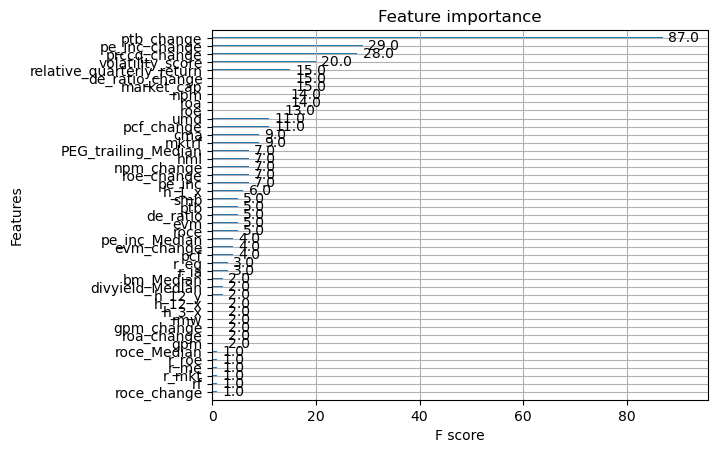

In [ ]:
plot_importance(model);

# Get the feature importance scores
importance = model.get_booster().get_score(importance_type='weight')

# Sort the features by importance
sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# Extract the most important features as a list of feature names (strings)
important_features = [feature for feature, score in sorted_importance[:5]]